<a href="https://colab.research.google.com/github/MarcosLaydner/ds_repo/blob/master/Assignment_2/Housing_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Enviroment preparation

In [0]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from google.colab import files
from zipfile import ZipFile
import matplotlib.pyplot as plt


In [0]:
# Install Kaggle library
!pip install -q kaggle

# Upload kaggle API key file if needed
# uploaded = files.upload()

# moves json file so the download commands works properly
# !cp kaggle.json ~/.kaggle/kaggle.json

# Or alternatively, type your credentials into the following variables
os.environ['KAGGLE_USERNAME'] = "user" # username from the json file
os.environ['KAGGLE_KEY'] = "key" # key from the json file

# Dataset download, storage and preprocessing

In [0]:
!kaggle competitions download -c santander-customer-transaction-prediction --force

santander_train = pd.read_csv('train.csv.zip', compression='zip', header=0, sep=',', quotechar='"')
santander_test = pd.read_csv('test.csv.zip', compression='zip', header=0, sep=',', quotechar='"')

!kaggle competitions download -c sberbank-russian-housing-market --force

zip_file = ZipFile('train.csv.zip')
housing_train = pd.read_csv(zip_file.open('train.csv'))
zip_file = ZipFile('test.csv.zip')
housing_test = pd.read_csv(zip_file.open('test.csv'))

 99% 124M/125M [00:03<00:00, 32.4MB/s]
100% 125M/125M [00:03<00:00, 41.8MB/s]
  0% 0.00/462k [00:00<?, ?B/s]
100% 462k/462k [00:00<00:00, 65.6MB/s]
 85% 106M/125M [00:00<00:00, 250MB/s] 
100% 125M/125M [00:01<00:00, 117MB/s]
  0% 0.00/25.4k [00:00<?, ?B/s]
100% 25.4k/25.4k [00:00<00:00, 25.2MB/s]
  0% 0.00/18.6k [00:00<?, ?B/s]
100% 18.6k/18.6k [00:00<00:00, 16.7MB/s]
  0% 0.00/4.46M [00:00<?, ?B/s]
100% 4.46M/4.46M [00:00<00:00, 73.1MB/s]
 53% 9.00M/17.1M [00:00<00:00, 17.6MB/s]
100% 17.1M/17.1M [00:00<00:00, 31.7MB/s]
  0% 0.00/66.5k [00:00<?, ?B/s]
100% 66.5k/66.5k [00:00<00:00, 68.7MB/s]


In [0]:
def missing_data_treatment(data):
  for i in data.columns:
    if data[i].dtype == 'object':
      data[i] = data[i].fillna(data[i].mode().iloc[0])
    if (data[i].dtype == 'int' or data[i].dtype == 'float'):
      data[i] = data[i].fillna(np.mean(data[i]))

def label_encoding(data, encoder):
  for i in data.columns:
    if (data[i].dtype == 'object'):
      data[i] = encoder.fit_transform(data[i].astype('str'))
      data[i] = data[i].astype('object')

In [0]:
missing_data_treatment(housing_train)
missing_data_treatment(housing_test)

number = LabelEncoder()
label_encoding(housing_train, number)
label_encoding(housing_test, number)

5326


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


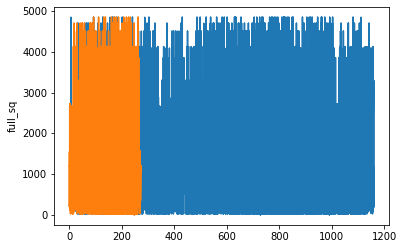

In [0]:
print(housing_train.full_sq.max())

plt.subplot()
plt.plot(housing_train.timestamp, housing_train.hospital_beds_raion)
plt.ylabel('full_sq')
plt.subplot()
plt.plot(housing_test.timestamp, housing_test.hospital_beds_raion)
plt.ylabel('full_sq')
plt.show()

In [0]:
santander_test

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,8.8100,-2.0248,-4.3554,13.9696,0.3458,7.5408,14.5001,7.7028,-19.0919,15.5806,16.1763,3.7088,18.8064,1.5899,3.0654,6.4509,14.1192,-9.4902,-2.1917,5.7107,3.7864,-1.7981,9.2645,2.0657,12.7753,11.3334,8.1462,-0.0610,3.5331,9.7804,...,5.9232,5.4113,3.8302,5.7380,-8.6105,22.9530,2.5531,-0.2836,4.3416,5.1855,4.2603,1.6779,29.0849,8.4685,18.1317,12.2818,-0.6912,10.2226,-5.5579,2.2926,-4.5358,10.3903,-15.4937,3.9697,31.3521,-1.1651,9.2874,-23.5705,13.2643,1.6591,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,5.9739,-1.3809,-0.3310,14.1129,2.5667,5.4988,14.1853,7.0196,4.6564,29.1609,0.0910,12.1469,3.1389,5.2578,2.4228,16.2064,13.5023,-5.2341,-3.6648,5.7080,2.9965,-10.4720,11.4938,-0.9660,15.3445,10.6361,0.8966,6.7428,2.3421,12.8678,...,30.9641,5.6723,3.6873,13.0429,-10.6572,15.5134,3.2185,9.0535,7.0535,5.3924,-0.7720,-8.1783,29.9227,-5.6274,10.5018,9.6083,-0.4935,8.1696,-4.3605,5.2110,0.4087,12.0030,-10.3812,5.8496,25.1958,-8.8468,11.8263,-8.7112,15.9072,0.9812,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,8.3442,-4.7057,-3.0422,13.6751,3.8183,10.8535,14.2126,9.8837,2.6541,21.2181,20.8163,12.4666,12.3696,4.7473,2.7936,5.2189,13.5670,-15.4246,-0.1655,7.2633,3.4310,-9.1508,9.7320,3.1062,22.3076,11.9593,9.9255,4.0702,4.9934,8.0667,...,39.3654,5.5228,3.3159,4.3324,-0.5382,13.3009,3.1243,-4.1731,1.2330,6.1513,-0.0391,1.4950,16.8874,-2.9787,27.4035,15.8819,-10.9660,15.6415,-9.4056,4.4611,-3.0835,8.5549,-2.8517,13.4770,24.4721,-3.4824,4.9178,-2.0720,11.5390,1.1821,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,7.4578,0.0095,-5.0659,14.0526,13.5010,8.7660,14.7352,10.0383,-15.3508,2.1273,21.4797,14.5372,12.5527,2.9707,4.2398,13.7796,14.1408,1.0061,-1.3479,5.2570,6.5911,6.2161,9.5540,2.3628,10.2124,10.8047,-2.5588,6.0720,3.2613,16.5632,...,19.7251,5.3882,3.6775,7.4753,-11.0780,24.8712,2.6415,2.2673,7.2788,5.6406,7.2048,3.4504,2.4130,11.1674,14.5499,10.6151,-5.7922,13.9407,7.1078,1.1019,9.4590,9.8243,5.9917,5.1634,8.1154,3.6638,3.3102,-19.7819,13.4499,1.3104,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,7.1437,5.1025,-3.2827,14.1013,8.9672,4.7276,14.5811,11.8615,3.1480,18.0126,13.8006,1.6026,16.3059,6.7954,3.6015,13.6569,13.8807,8.6228,-2.2654,5.2255,7.0165,-15.6961,10.6239,-4.7674,17.5447,11.8668,3.0154,4.2546,6.7601,5.9613,...,22.8700,5.6688,6.1159,13.2433,-11.9785,26.2040,3.2348,-5.5775,5.7036,6.1717,-1.6039,-2.4866,17.2728,2.3640,14.0037,12.9165,-12.0311,10.1161,-8.7562,6.0889,-1.3620,10.3559,-7.4915,9.4588,3.9829,5.8580,8.3635,-24.8254,11.4928,1.6321,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,test_199995,13.

# Functions for checking Covariate Shift

In [0]:
def compare_train_test_distribution(train, test, col, bins):  
  N_points = 100000
  n_bins = bins

  x = train[col]
  y = test[col]

  fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

  # We can set the number of bins with the `bins` kwarg
  axs[0].hist(x, bins=n_bins)
  axs[1].hist(y, bins=n_bins)

def concat(train_df, test_df, id_column, y):
  train_df.drop(columns=[id_column, y], inplace=True)
  test_df.drop(columns=[id_column], inplace=True)

  train_df['is_test'] = 0
  test_df['is_test'] = 1
  df = pd.concat([train_df, test_df], axis = 0)
  return df

def shuffle_split(df):
  X = df.drop(columns=['is_test'])
  y = df['is_test']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)
  print('train2 shape:', X_train.shape, 'test2 shape:', X_test.shape)
  return X_train, X_test, y_train, y_test


def test_shift(X_train, X_test, y_train, y_test):
  rfc = RandomForestClassifier()
  rfc.fit(X_train, y_train)
  y_test_score = rfc.predict_proba(X_test)

  print('AUC score: ', round(roc_auc_score(y_true=y_test, y_score=y_test_score[:,1]), 4))

# Applying the functions to the data

with a score of around 0.5, it is safe to assume minimun to no covariate shift

train2 shape: (26693, 290) test2 shape: (11440, 290)
AUC score:  1.0


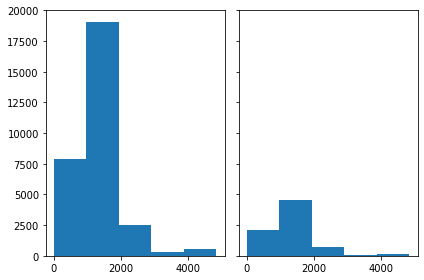

In [0]:
# Applying to housing set
housing_train_c = housing_train.copy()
housing_test_c = housing_test.copy()

compare_train_test_distribution(housing_train_c, housing_test_c, 'hospital_beds_raion', 5)

concat_df = concat(housing_train_c, housing_test_c, 'id', 'price_doc')
param = shuffle_split(concat_df)

test_shift(param[0], param[1], param[2], param[3])

score of 1.0 indicating total shift

# Identifying problematic features

In [0]:
y = concat_df['is_test']
model = RandomForestClassifier(n_estimators = 50, max_depth = 5,min_samples_leaf = 5)
drop_list = []
for i in concat_df.columns:
  score = cross_val_score(model,pd.DataFrame(concat_df[i]),y,cv=2,scoring='roc_auc')
  if (np.mean(score) > 0.8):
    drop_list.append(i)
    print(i,np.mean(score))
drop_list

life_sq 0.8053606325033835
kitch_sq 0.8364615526405887
hospital_beds_raion 0.8762529920030994
cafe_sum_500_min_price_avg 0.8310805313871339
cafe_sum_500_max_price_avg 0.8301182206553556
cafe_avg_price_500 0.8282560886052324
is_test 1.0


['life_sq',
 'kitch_sq',
 'hospital_beds_raion',
 'cafe_sum_500_min_price_avg',
 'cafe_sum_500_max_price_avg',
 'cafe_avg_price_500',
 'is_test']

# Determining the importance of the drifting features

In [0]:
rf = RandomForestRegressor(n_estimators=200, max_depth=6,max_features=10)
rf.fit(housing_train.drop('price_doc',axis=1),housing_train['price_doc'])
pred = rf.predict(housing_test)
columns = ['price_doc']
sub = pd.DataFrame(data=pred,columns=columns)
sub['id'] = housing_test['id']
sub = sub[['id','price_doc']]
sub.to_csv('with_drifting.csv', index=False)

!kaggle competitions submit -c sberbank-russian-housing-market -f with_drifting.csv -m "with drifting"

100% 180k/180k [00:09<00:00, 19.5kB/s]
Successfully submitted to Sberbank Russian Housing Market

RMSE of the submitted model with drifting is 0.40540

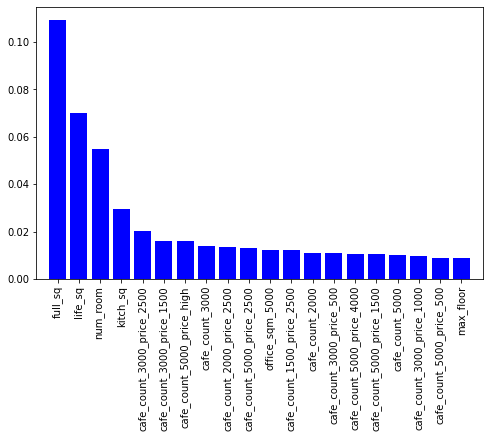

In [0]:
features = housing_train.drop('price_doc',axis=1).columns.values
imp = rf.feature_importances_
indices = np.argsort(imp)[::-1][:20]

#plot
plt.figure(figsize=(8,5))
plt.bar(range(len(indices)), imp[indices], color = 'b', align='center')
plt.xticks(range(len(indices)), features[indices], rotation='vertical')
plt.xlim([-1,len(indices)])
plt.show()

This way, it is possible to conclude that among the 4 most important features, two are in the drifting list

## Testing the performance without the problem features

In [0]:
drop_list.remove('is_test')
drift_train = housing_train.drop(columns=drop_list)
drift_test = housing_test.drop(columns=drop_list)

rf = RandomForestRegressor(n_estimators=200, max_depth=6,max_features=10)
rf.fit(drift_train.drop('price_doc',axis=1),housing_train['price_doc'])
pred = rf.predict(drift_test)
columns = ['price_doc']
sub = pd.DataFrame(data=pred,columns=columns)
sub['id'] = housing_test['id']
sub = sub[['id','price_doc']]
sub.to_csv('without_drifting.csv', index=False)

!kaggle competitions submit -c sberbank-russian-housing-market -f without_drifting.csv -m "without drifting"

100% 180k/180k [00:07<00:00, 23.5kB/s]
Successfully submitted to Sberbank Russian Housing Market

The score for this one was 0.41349, worse than the one with the drifting feature

## Removing only the non-important drifting features

In [0]:
drop_list.remove('life_sq')
drop_list.remove('kitch_sq')

drift_train = housing_train.drop(columns=drop_list)
drift_test = housing_test.drop(columns=drop_list)

rf = RandomForestRegressor(n_estimators=200, max_depth=6,max_features=10)
rf.fit(drift_train.drop('price_doc',axis=1),housing_train['price_doc'])
pred = rf.predict(drift_test)
columns = ['price_doc']
sub = pd.DataFrame(data=pred,columns=columns)
sub['id'] = housing_test['id']
sub = sub[['id','price_doc']]
sub.to_csv('without_uninportant_drifting.csv', index=False)

!kaggle competitions submit -c sberbank-russian-housing-market -f without_uninportant_drifting.csv -m "without_uninportant_drifting"

100% 180k/180k [00:07<00:00, 23.2kB/s]
Successfully submitted to Sberbank Russian Housing Market

The score now dropped to 0.39996, a small improvement, but a improvement nonetheless